In [ ]:
import pandas as pd
import os
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose # type: ignore
from statsmodels.tsa.stattools import adfuller
from scipy.stats import median_abs_deviation
import warnings

In [ ]:
base_dir = os.getcwd()
demandas_path = os.path.join(
    base_dir, "..","..", "data", "processed","Alcala_Henares", "datos_Alcala_Henares_transformados.csv"
)
df = pd.read_csv(demandas_path)

In [3]:
df.columns

Index(['fecha', 'tmed', 'tmin', 'tmax', 'velmedia', 'hrMedia'], dtype='object')

## TRATAMIENTO OUTLIERS

### TEMPERATURA MEDIA

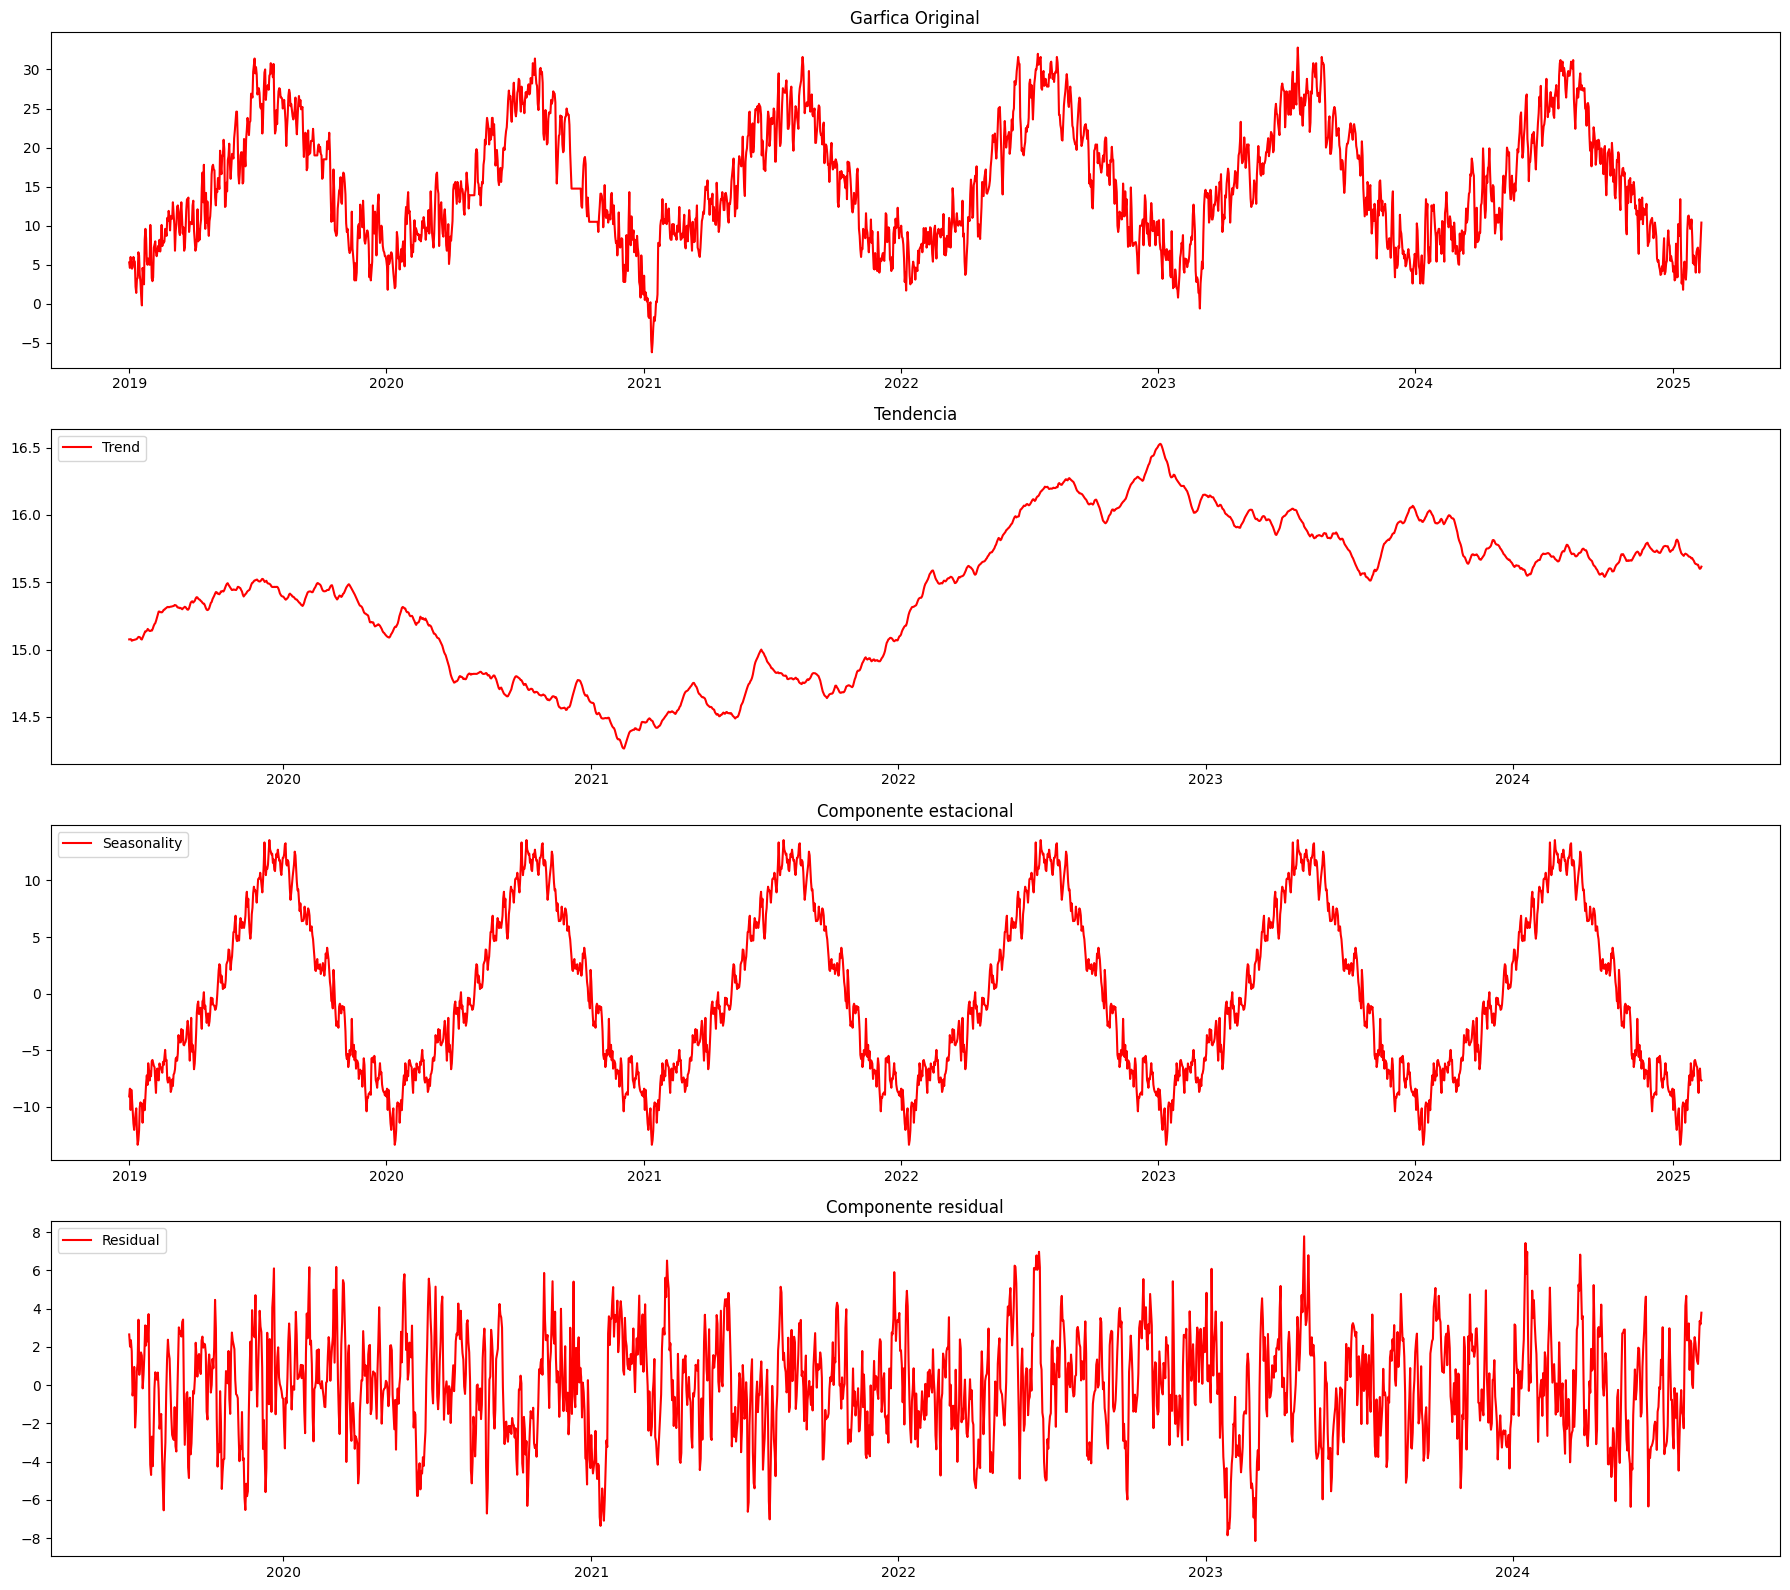

In [4]:
df["fecha"] = pd.to_datetime(df["fecha"])
# Descomponer la serie temporal de la temperatura media para mostrar la tendencia, estacionalidad y residuos
decomposition_temp = seasonal_decompose(df["tmed"], model='adittive', period=365)


plt.figure(figsize=(18, 16))

plt.subplot(4, 1, 1)
plt.plot(df["fecha"], df["tmed"], color="red")
plt.title('Garfica Original')

plt.subplot(4, 1, 2)
plt.plot(df["fecha"], decomposition_temp.trend, label='Trend', color="red")
plt.legend(loc='upper left')
plt.title('Tendencia')

plt.subplot(4, 1, 3)
plt.plot(df["fecha"], decomposition_temp.seasonal, label='Seasonality', color="red")
plt.legend(loc='upper left')
plt.title('Componente estacional')

plt.subplot(4, 1, 4)
plt.plot(df["fecha"], decomposition_temp.resid, label='Residual', color="red")
plt.legend(loc='upper left')
plt.title('Componente residual')

plt.tight_layout()
plt.show()

- Media móvil de la temperatura dentro de una ventana de 90 días.

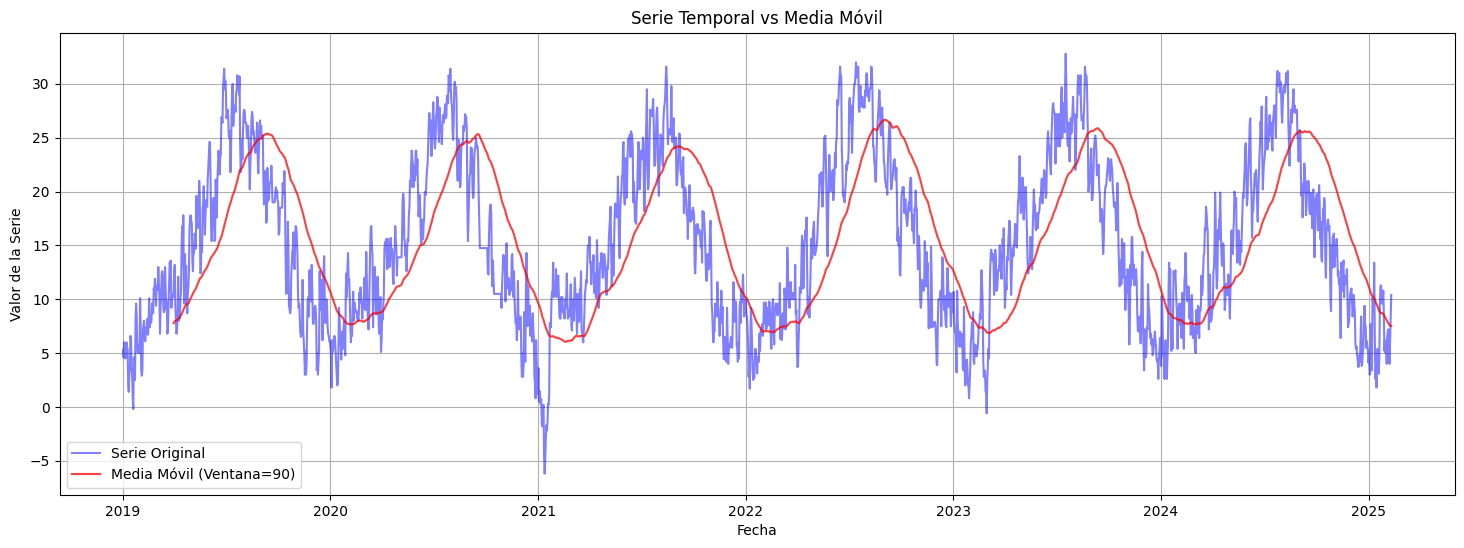

In [5]:
# Se puede ver que la media no varía mucho solo cambia ligeramente en 2022

# Tamaño de la ventana para la media móvil
window_size = 90  

# Calcula la media móvil
df['Rolling_Avg'] = df["tmed"].rolling(window=window_size).mean()

# Graficar la serie original y la media móvil
plt.figure(figsize=(18, 6))
plt.plot(df["fecha"], df['tmed'], label='Serie Original', color='blue', alpha=0.5)
plt.plot(df["fecha"], df['Rolling_Avg'], label=f'Media Móvil (Ventana={window_size})', color='red', alpha=0.75)


plt.title('Serie Temporal vs Media Móvil')
plt.xlabel('Fecha')
plt.ylabel('Valor de la Serie')
plt.legend()
plt.grid(True)
plt.show()


df.drop(columns=["Rolling_Avg"], inplace=True)

- Varianza de la temperatura dentro de una ventana de 30 días.

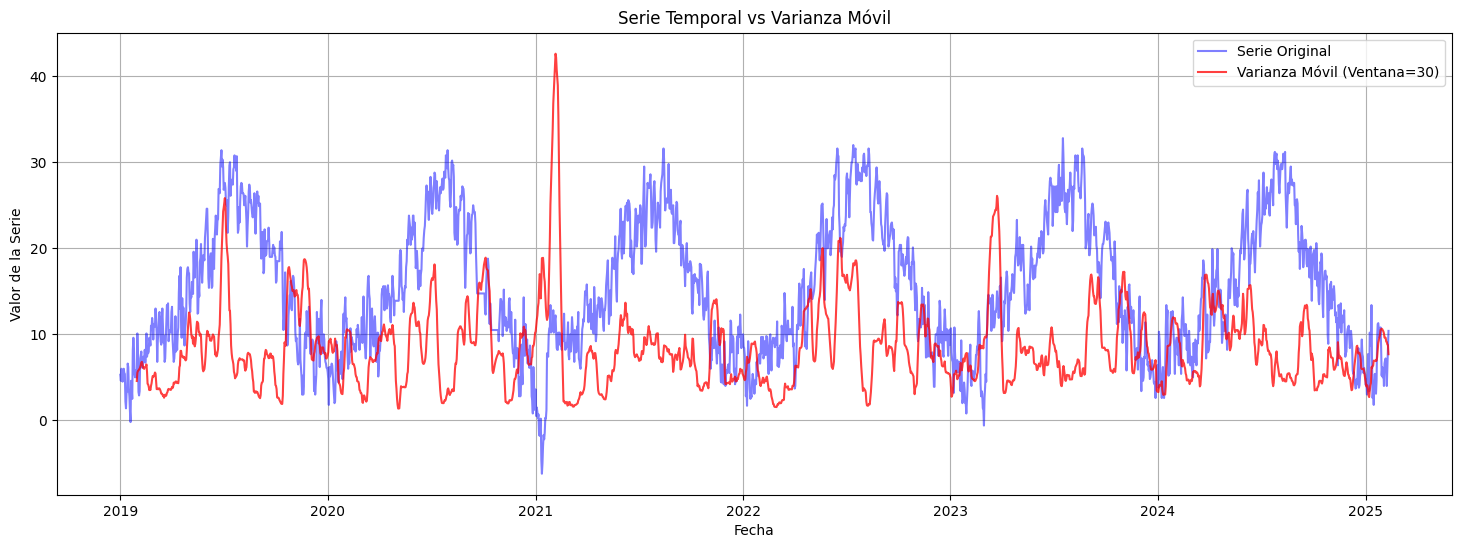

In [6]:
# Se puede ver que la varianza varia mas que la media y hay un pico en 2021 

# Tamaño de la ventana para la media móvil
window_size = 30  

# Calcula la media móvil
df['Rolling_var'] = df["tmed"].rolling(window=window_size).var()

# Graficar la serie original y la media móvil
plt.figure(figsize=(18, 6))
plt.plot(df["fecha"], df['tmed'], label='Serie Original', color='blue', alpha=0.5)
plt.plot(df["fecha"], df['Rolling_var'], label=f'Varianza Móvil (Ventana={window_size})', color='red', alpha=0.75)


plt.title('Serie Temporal vs Varianza Móvil')
plt.xlabel('Fecha')
plt.ylabel('Valor de la Serie')
plt.legend()
plt.grid(True)
plt.show()


df.drop(columns=["Rolling_var"], inplace=True)

### DETECCIÓN DE OUTLIERS CON MEDIA MÓVIL Y DESVIACIÓN ESTANDAR

- Creo un rango donde si la serie temporal lo sobrepasa, se considera como outlier.

In [7]:
window = 90  # 30 days window
threshold = 1.5  # Threshold of 2 standard deviations

ma = df["tmed"].rolling(window=window, center=True).mean()
std = df["tmed"].rolling(window=window, center=True).std()

#Treshold min and max
threshold_min = ma - std*threshold 
threshold_max = ma + std*threshold 

#Outliers detection
df["outlier_ma"] = (np.abs(df["tmed"] - ma) > threshold * std)

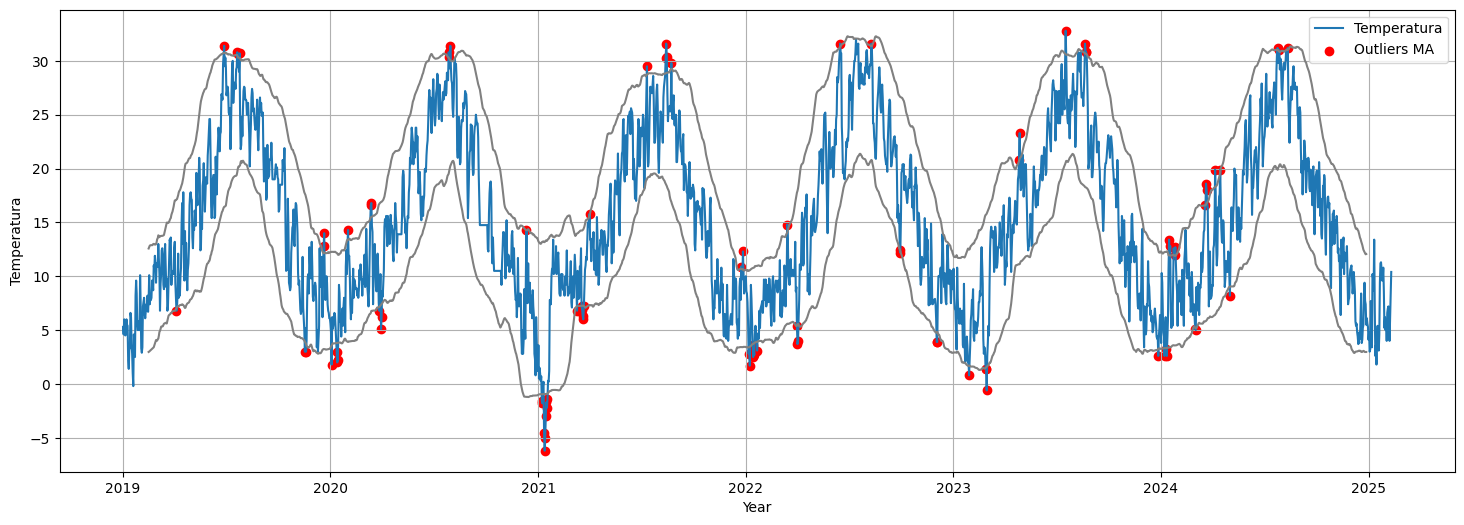

In [8]:

plt.figure(figsize=(18, 6))

plt.plot(df['fecha'], df['tmed'], label='Temperatura')
plt.plot(df['fecha'], threshold_min, color='gray')
plt.plot(df['fecha'], threshold_max, color='gray')
plt.scatter(df["fecha"][df["outlier_ma"]], df["tmed"][df["outlier_ma"]], color='red', label="Outliers MA")
plt.xlabel('Year')
plt.ylabel('Temperatura')
plt.legend()
plt.grid(True)
plt.show()


- Sustituyo los outliers por la interpolación lineal.

In [9]:
window = 90  # Tamaño de la ventana
# df["tmed_imputed"] = df["tmed"].where(~df["outlier_ma"], df["tmed"].rolling(window=window, center=True).mean())

# Marcar los outliers como NaN
df["tmed_imputed"] = df["tmed"].where(~df["outlier_ma"], np.nan)

# Interpolación lineal
df["tmed_imputed"] = df["tmed_imputed"].interpolate(method="linear")

- Vuelvo a crear el rango para ver si sigue habiendo outliers.

In [10]:
window = 90  # 90 days window
threshold = 2  # Threshold of 2 standard deviations

ma = df["tmed_imputed"].rolling(window=window, center=True).mean()
std = df["tmed_imputed"].rolling(window=window, center=True).std()

#Treshold min and max
threshold_min = ma - std*threshold 
threshold_max = ma + std*threshold 

#Outliers detection
df["outlier_ma"] = (np.abs(df["tmed_imputed"] - ma) > threshold * std)

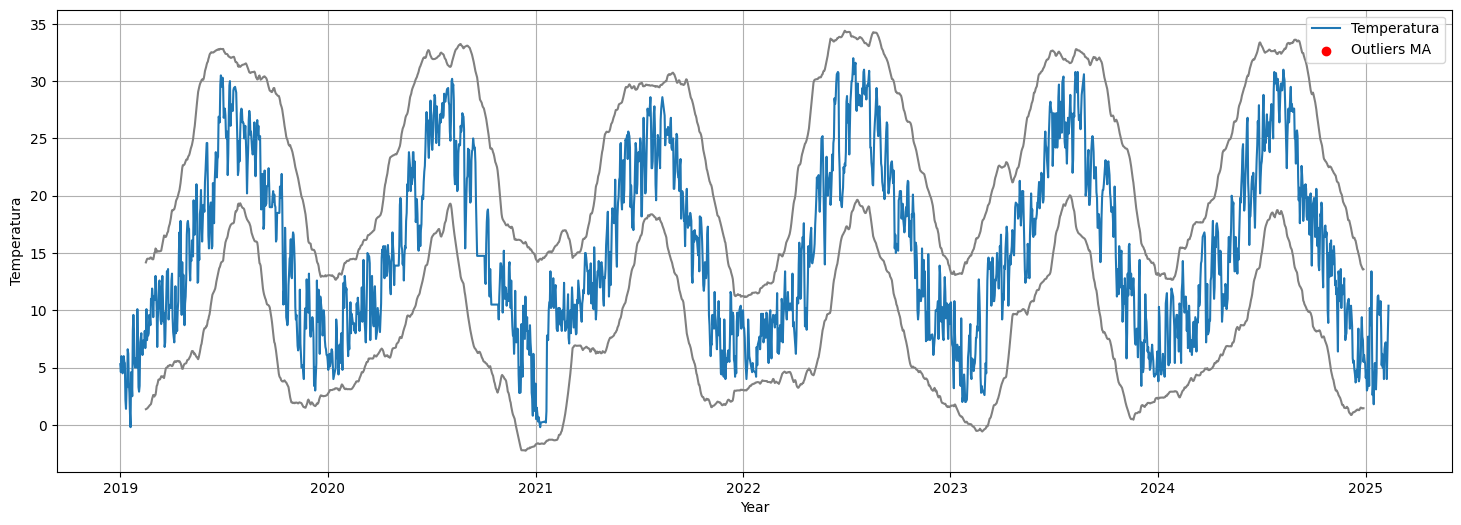

In [11]:
# Gráfica despúes de quitar los outliers
plt.figure(figsize=(18, 6))

plt.plot(df['fecha'], df['tmed_imputed'], label='Temperatura')
plt.plot(df['fecha'], threshold_min, color='gray')
plt.plot(df['fecha'], threshold_max, color='gray')
plt.scatter(df["fecha"][df["outlier_ma"]], df["tmed_imputed"][df["outlier_ma"]], color='red', label="Outliers MA")
plt.xlabel('Year')
plt.ylabel('Temperatura')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
# Los valores entre tmed y tmed_imputed no varían menos en el min 
df[["tmed","tmed_imputed"]].describe()

tmed  tmed_imputed
count  2233.000000   2233.000000
mean     15.225280     15.243775
std       7.712808      7.589963
min      -6.200000     -0.200000
25%       9.000000      9.100000
50%      14.200000     14.200000
75%      21.300000     21.300000
max      32.800000     32.000000

In [13]:
# Nos quedamos con los valores sin outliers y borraos la columna
df["tmed"] = df["tmed_imputed"]
df.drop(columns = ["tmed_imputed","outlier_ma"], inplace=True)

### Comprobar si los datos son estacionarios

- El test de dickey duller detecta si existe una raíz unitaria en la serie temporal. Si la hay significa que no es estacionaria.

In [14]:
# Realizar el Test ADF (Dickey-Fuller Aumentado)
adf_result = adfuller(df["tmed"])

# Imprimir los resultados del test ADF
print("Estadística de prueba ADF:", adf_result[0])
print("Valor p:", adf_result[1])
print("Valores críticos:", adf_result[4])

# Interpretación del resultado
if adf_result[1] < 0.05:
    print("Rechazamos la hipótesis nula: La serie es estacionaria")
else:
    print("No podemos rechazar la hipótesis nula: La serie tiene una raíz unitaria y no es estacionaria")

Estadística de prueba ADF: -2.9707726666703698
Valor p: 0.03771548888733448
Valores críticos: {'1%': -3.4332990438642623, '5%': -2.8628427996988957, '10%': -2.567463542934827}
Rechazamos la hipótesis nula: La serie es estacionaria


### TEMPERATURA MÍNIMA

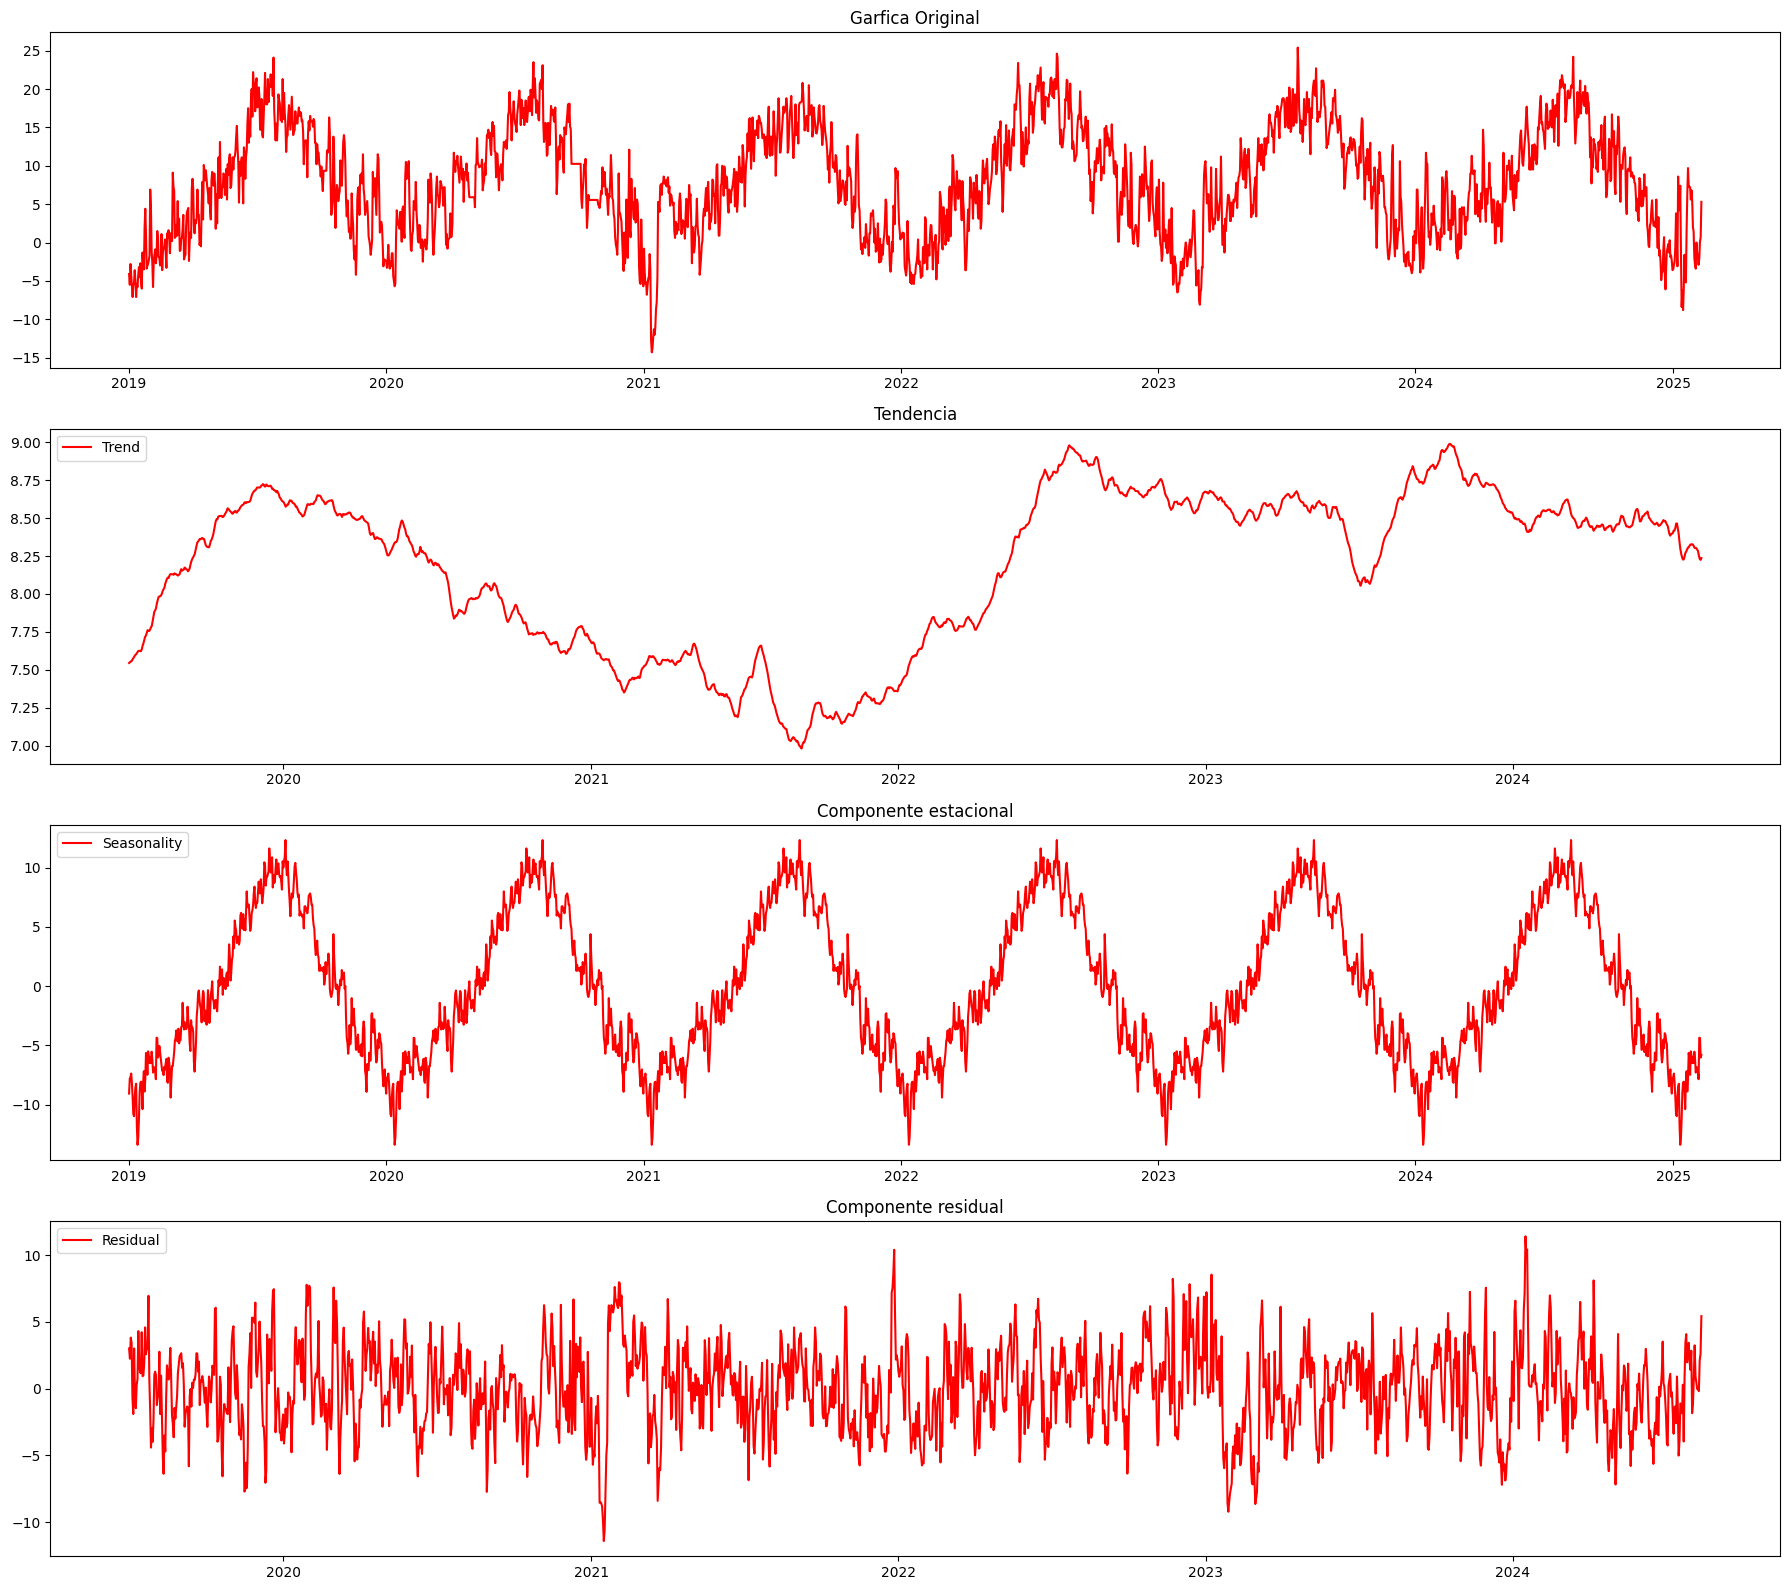

In [15]:
df["fecha"] = pd.to_datetime(df["fecha"])
# Descomponer la serie temporal de la temperatura mínima para mostrar la tendencia, estacionalidad y residuos
decomposition_temp_min = seasonal_decompose(df["tmin"], model='adittive', period=365)


plt.figure(figsize=(18, 16))

plt.subplot(4, 1, 1)
plt.plot(df["fecha"], df["tmin"], color="red")
plt.title('Garfica Original')

plt.subplot(4, 1, 2)
plt.plot(df["fecha"], decomposition_temp_min.trend, label='Trend', color="red")
plt.legend(loc='upper left')
plt.title('Tendencia')

plt.subplot(4, 1, 3)
plt.plot(df["fecha"], decomposition_temp_min.seasonal, label='Seasonality', color="red")
plt.legend(loc='upper left')
plt.title('Componente estacional')

plt.subplot(4, 1, 4)
plt.plot(df["fecha"], decomposition_temp_min.resid, label='Residual', color="red")
plt.legend(loc='upper left')
plt.title('Componente residual')

plt.tight_layout()
plt.show()

- Media móvil de la temperatura mínima dentro de una ventana de 90 días.

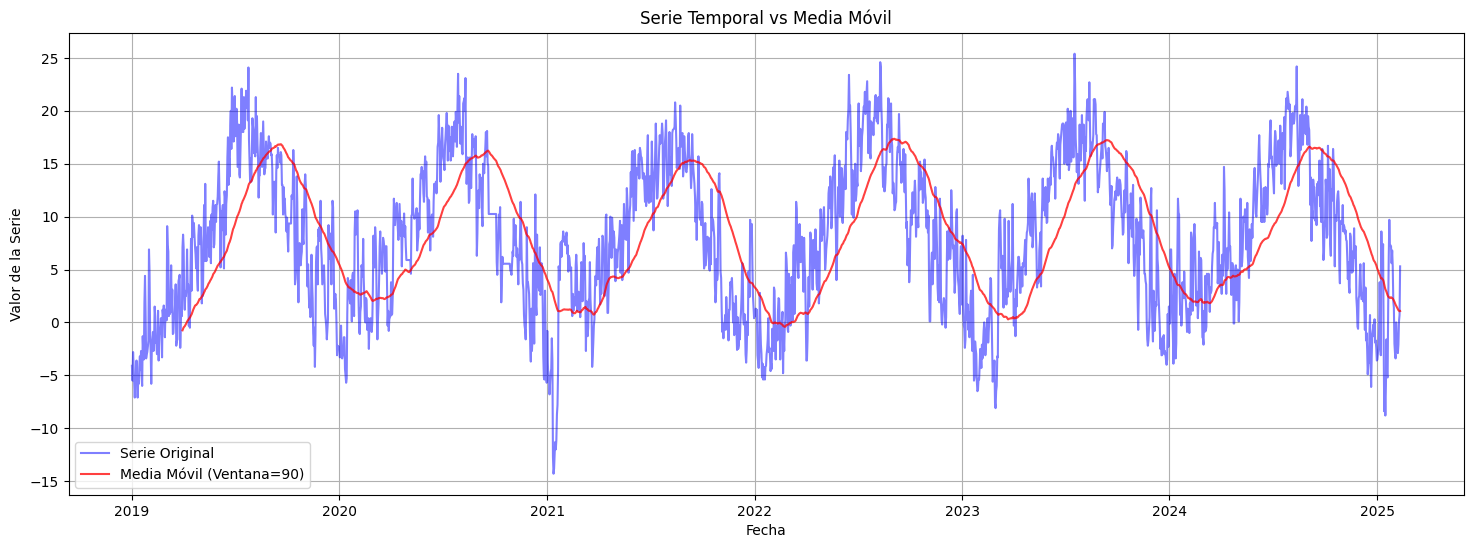

In [16]:
# Se puede ver que la media no varía mucho solo cambia ligeramente en 2022

# Tamaño de la ventana para la media móvil
window_size = 90  

# Calcula la media móvil
df['Rolling_Avg'] = df["tmin"].rolling(window=window_size).mean()

# Graficar la serie original y la media móvil
plt.figure(figsize=(18, 6))
plt.plot(df["fecha"], df['tmin'], label='Serie Original', color='blue', alpha=0.5)
plt.plot(df["fecha"], df['Rolling_Avg'], label=f'Media Móvil (Ventana={window_size})', color='red', alpha=0.75)


plt.title('Serie Temporal vs Media Móvil')
plt.xlabel('Fecha')
plt.ylabel('Valor de la Serie')
plt.legend()
plt.grid(True)
plt.show()


df.drop(columns=["Rolling_Avg"], inplace=True)

- Varianza de la temperatura mínima dentro de una ventana de 30 días.

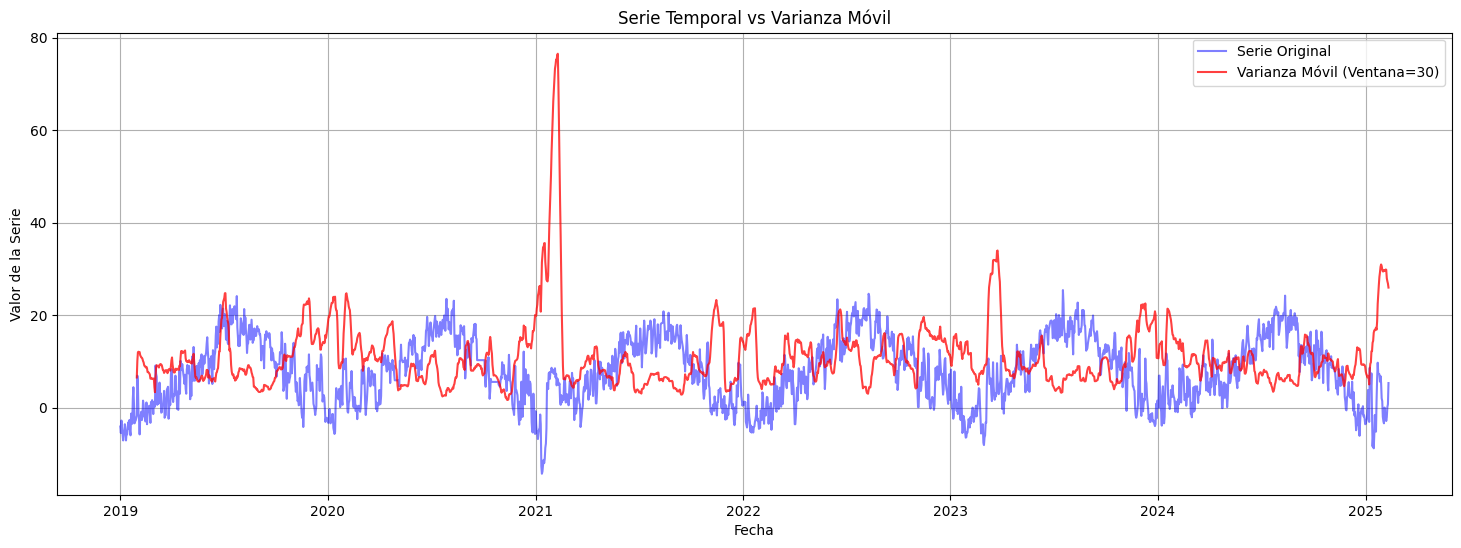

In [17]:
# Se puede ver que la varianza varia mas que la media y hay un pico en 2021 

# Tamaño de la ventana para la media móvil
window_size = 30  

# Calcula la media móvil
df['Rolling_var'] = df["tmin"].rolling(window=window_size).var()

# Graficar la serie original y la media móvil
plt.figure(figsize=(18, 6))
plt.plot(df["fecha"], df['tmin'], label='Serie Original', color='blue', alpha=0.5)
plt.plot(df["fecha"], df['Rolling_var'], label=f'Varianza Móvil (Ventana={window_size})', color='red', alpha=0.75)


plt.title('Serie Temporal vs Varianza Móvil')
plt.xlabel('Fecha')
plt.ylabel('Valor de la Serie')
plt.legend()
plt.grid(True)
plt.show()


df.drop(columns=["Rolling_var"], inplace=True)

### DETECCIÓN DE OUTLIERS MEDIANTE EL FILTRO HAMPEL

- Detecta los outliers dentro de una ventana utlizando la mediana ya que la mediana no suele ser muy afectada por outliers.

In [18]:
window_size=30
n_sigma=3

#Calculate the median in a rolling centered window
rolling_median = df["tmin"].rolling(window_size, center=True).median()

#Calculate the median of the absolute deviations from the data’s median in a rolling centered window
mad = df["tmin"].rolling(window_size, center=True).apply(median_abs_deviation)

#Treshold 
threshold_min = rolling_median - n_sigma*mad
threshold_max = rolling_median + n_sigma*mad

df["outlier_hm"] = (np.abs(df["tmin"] - rolling_median) > n_sigma*mad)

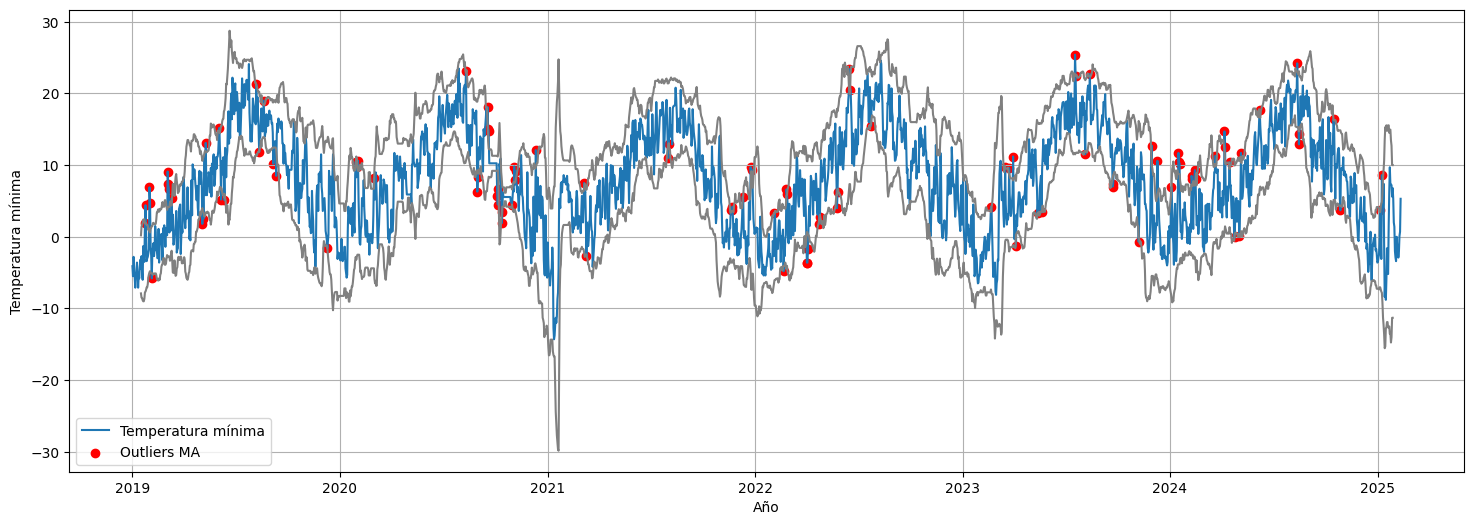

In [19]:
plt.figure(figsize=(18, 6))

plt.plot(df['fecha'], df['tmin'], label='Temperatura mínima')
plt.plot(df['fecha'], threshold_min, color='gray')
plt.plot(df['fecha'], threshold_max, color='gray')
plt.scatter(df["fecha"][df["outlier_hm"]], df["tmin"][df["outlier_hm"]], color='red', label="Outliers MA")
plt.xlabel('Año')
plt.ylabel('Temperatura mínima')
plt.legend()
plt.grid(True)
plt.show()


- Se detectan los outliers y se les imputa el valor calculado anteriormente, que esta representado como la linea gris.

In [20]:
# Imputar los outliers para que no superen el umbral
df["tmin_imputed"] = df["tmin"].copy()  # Copiar la columna original

# Reemplazar valores por debajo del umbral mínimo con el umbral mínimo
df.loc[df["tmin"] < threshold_min, "tmin_imputed"] = threshold_min

# Reemplazar valores por encima del umbral máximo con el umbral máximo
df.loc[df["tmin"] > threshold_max, "tmin_imputed"] = threshold_max

- Gráfica que muestra los outliers de antes y su valor actual después de imputarlos

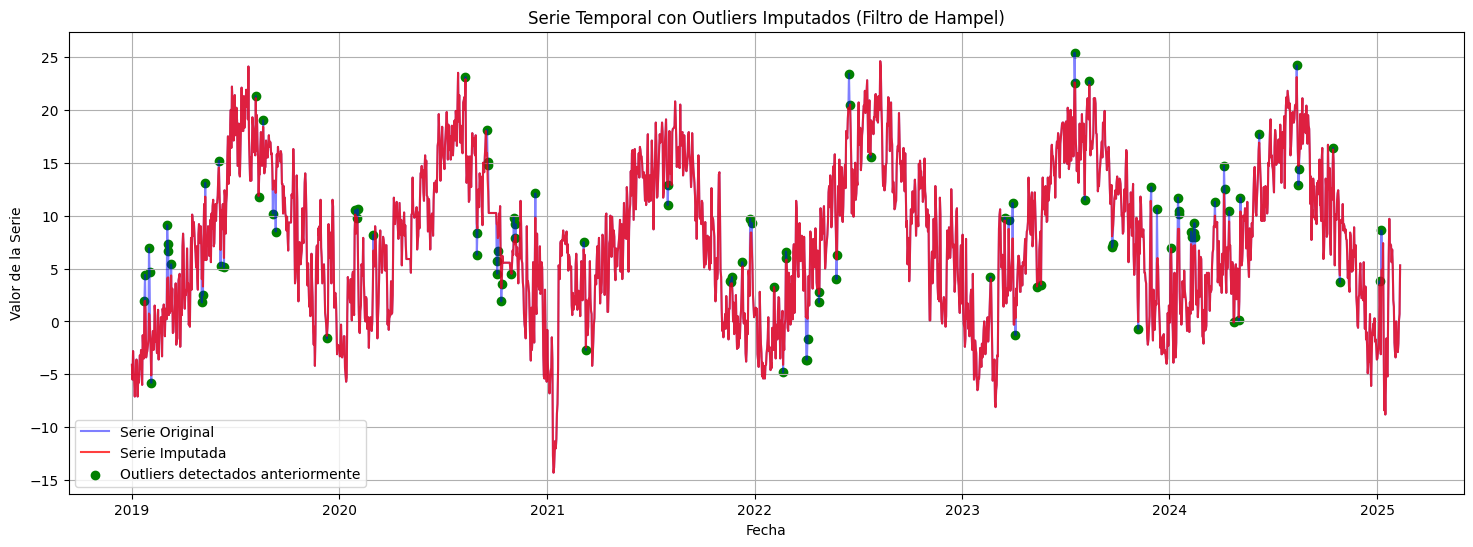

In [21]:
plt.figure(figsize=(18, 6))

# Serie temporal original
plt.plot(df["fecha"], df["tmin"], label="Serie Original", color="blue", alpha=0.5)

# Serie temporal con outliers imputados
plt.plot(df["fecha"], df["tmin_imputed"], label="Serie Imputada", color="red", alpha=0.75)

# Valores atípicos
outliers = df[df["outlier_hm"]]
plt.scatter(outliers["fecha"], outliers["tmin"], color="green", label="Outliers detectados anteriormente")


plt.title("Serie Temporal con Outliers Imputados (Filtro de Hampel)")
plt.xlabel("Fecha")
plt.ylabel("Valor de la Serie")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
df.columns

Index(['fecha', 'tmed', 'tmin', 'tmax', 'velmedia', 'hrMedia', 'outlier_hm',
       'tmin_imputed'],
      dtype='object')

In [23]:
df["tmin"] = df["tmin_imputed"]
df.drop(columns=["outlier_hm","tmin_imputed"], inplace = True)

### Comprobar si los datos son estacionarios

- El test de dickey duller detecta si existe una raíz unitaria en la serie temporal. Si la hay significa que no es estacionaria.

In [24]:
# Realizar el Test ADF (Dickey-Fuller Aumentado)
adf_result = adfuller(df["tmin"])

# Imprimir los resultados del test ADF
print("Estadística de prueba ADF:", adf_result[0])
print("Valor p:", adf_result[1])
print("Valores críticos:", adf_result[4])

# Interpretación del resultado
if adf_result[1] < 0.05:
    print("Rechazamos la hipótesis nula: La serie es estacionaria")
else:
    print("No podemos rechazar la hipótesis nula: La serie tiene una raíz unitaria y no es estacionaria")

Estadística de prueba ADF: -3.7197540601475425
Valor p: 0.00384372123217391
Valores críticos: {'1%': -3.4332990438642623, '5%': -2.8628427996988957, '10%': -2.567463542934827}
Rechazamos la hipótesis nula: La serie es estacionaria


### TEMPERATURA MÁXIMA

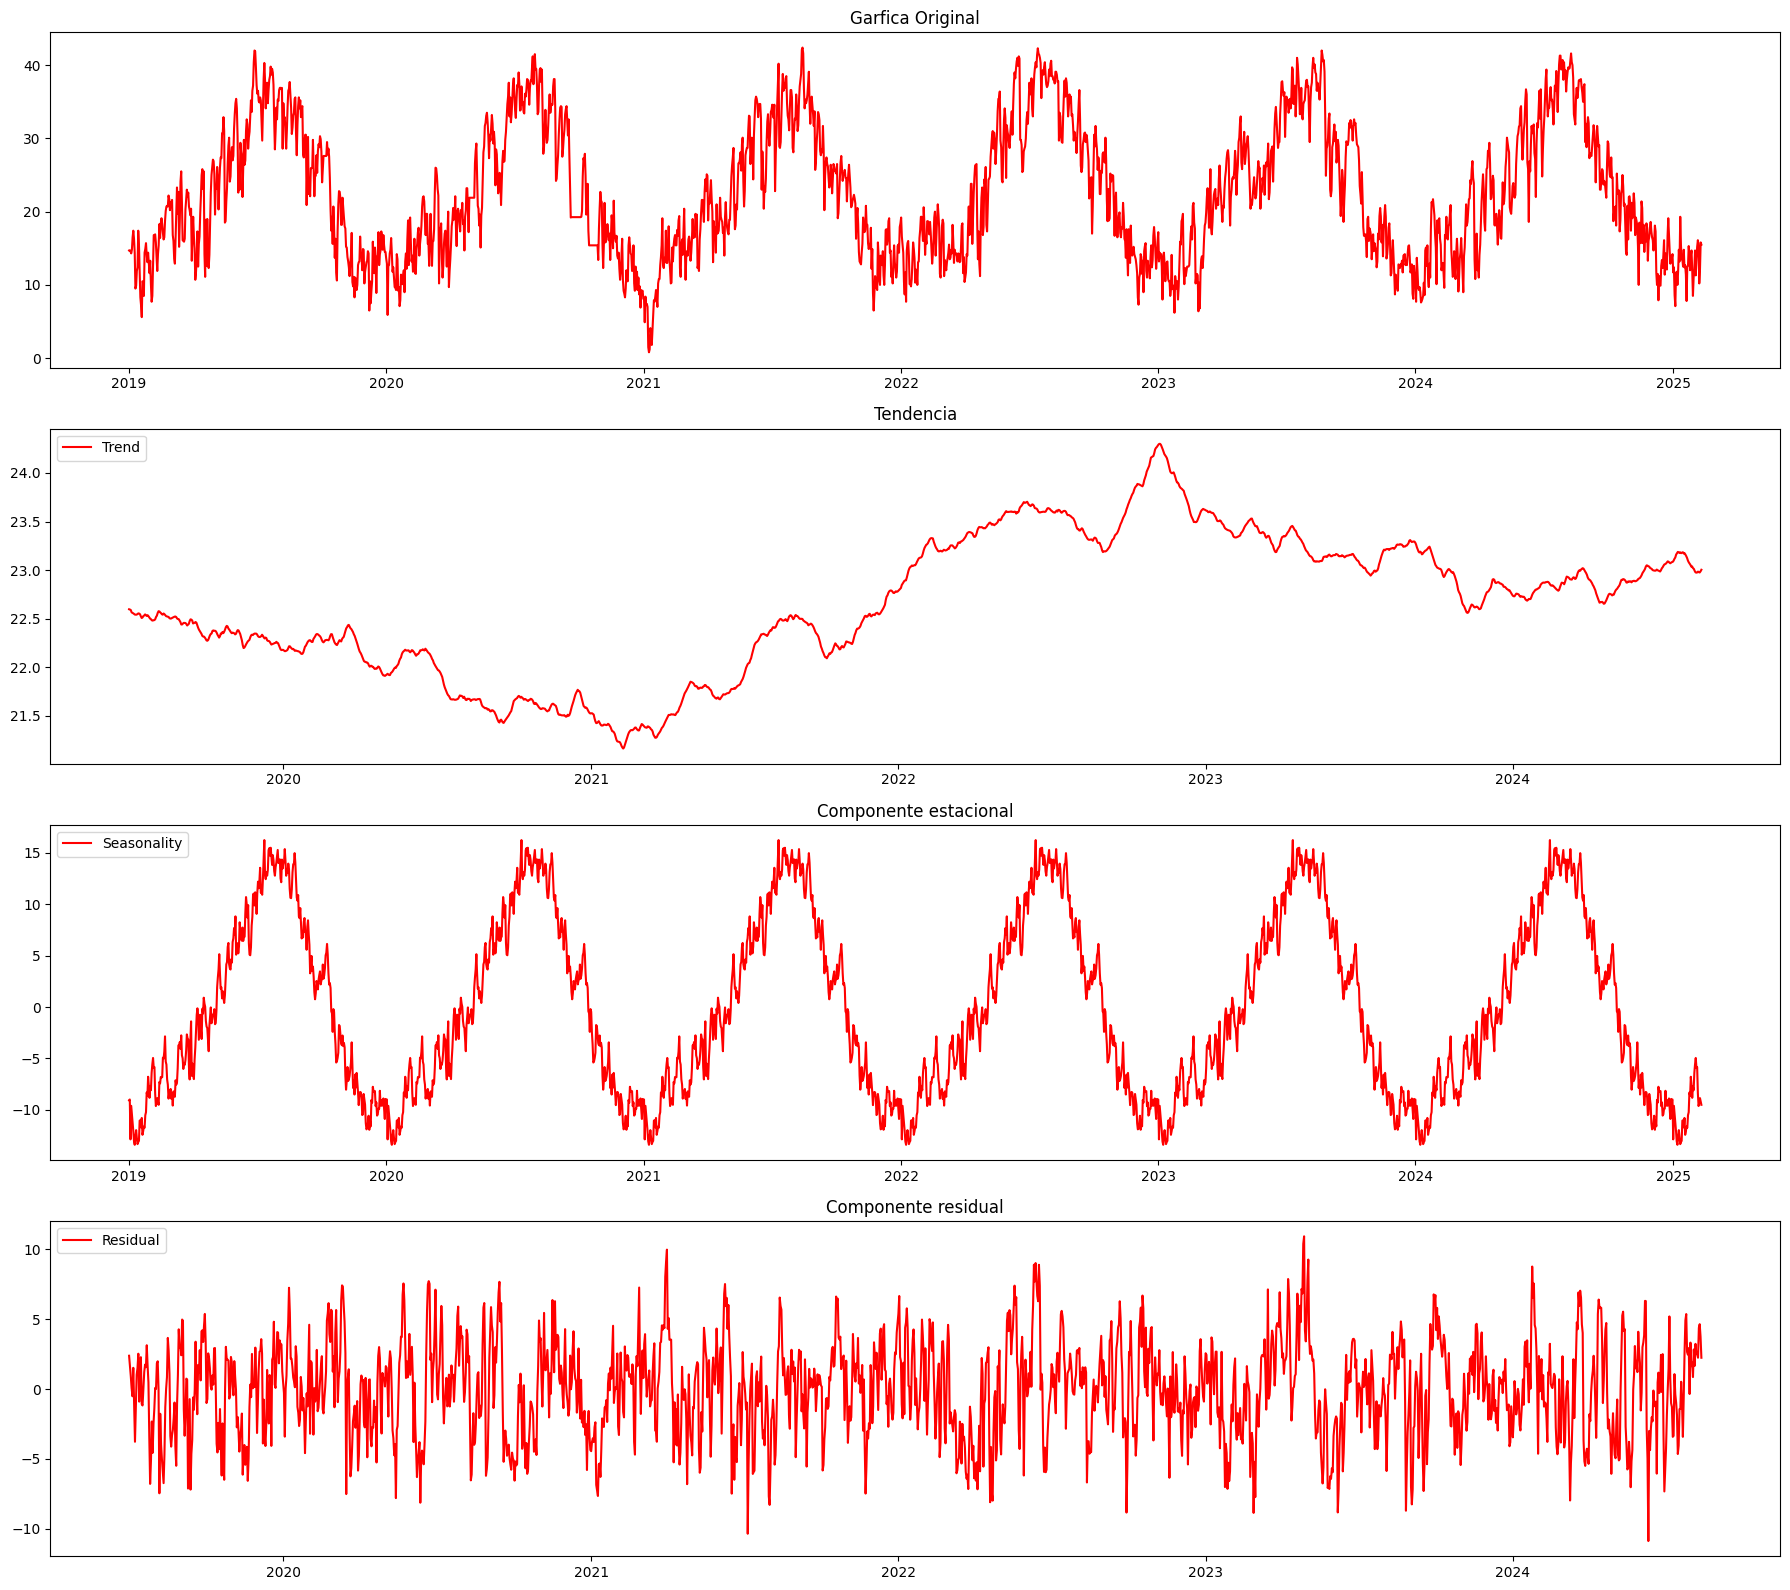

In [25]:
df["fecha"] = pd.to_datetime(df["fecha"])
# Descomponer la serie tenporal de la temperatura máxima para mostrar la tendencia, estacionalidad y residuos
decomposition_temp_max = seasonal_decompose(df["tmax"], model='adittive', period=365)


plt.figure(figsize=(18, 16))

plt.subplot(4, 1, 1)
plt.plot(df["fecha"], df["tmax"], color="red")
plt.title('Garfica Original')

plt.subplot(4, 1, 2)
plt.plot(df["fecha"], decomposition_temp_max.trend, label='Trend', color="red")
plt.legend(loc='upper left')
plt.title('Tendencia')

plt.subplot(4, 1, 3)
plt.plot(df["fecha"], decomposition_temp_max.seasonal, label='Seasonality', color="red")
plt.legend(loc='upper left')
plt.title('Componente estacional')

plt.subplot(4, 1, 4)
plt.plot(df["fecha"], decomposition_temp_max.resid, label='Residual', color="red")
plt.legend(loc='upper left')
plt.title('Componente residual')

plt.tight_layout()
plt.show()

- Media movil de la temperatura máxima dentro de una ventana de 90 días.

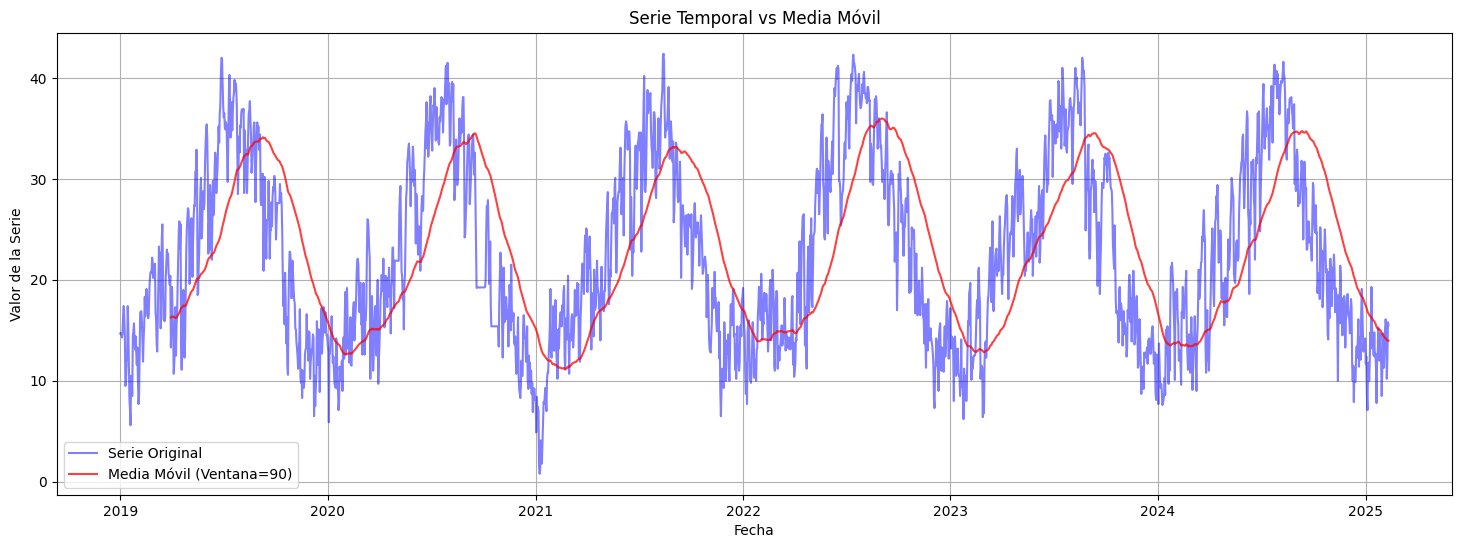

In [26]:
# Se puede ver que la media no varía mucho solo cambia ligeramente en 2022

# Tamaño de la ventana para la media móvil
window_size = 90  

# Calcula la media móvil
df['Rolling_Avg'] = df["tmax"].rolling(window=window_size).mean()

# Graficar la serie original y la media móvil
plt.figure(figsize=(18, 6))
plt.plot(df["fecha"], df['tmax'], label='Serie Original', color='blue', alpha=0.5)
plt.plot(df["fecha"], df['Rolling_Avg'], label=f'Media Móvil (Ventana={window_size})', color='red', alpha=0.75)


plt.title('Serie Temporal vs Media Móvil')
plt.xlabel('Fecha')
plt.ylabel('Valor de la Serie')
plt.legend()
plt.grid(True)
plt.show()


df.drop(columns=["Rolling_Avg"], inplace=True)

- Ventana móvil de la varianza dentro de una ventana de 30 días.

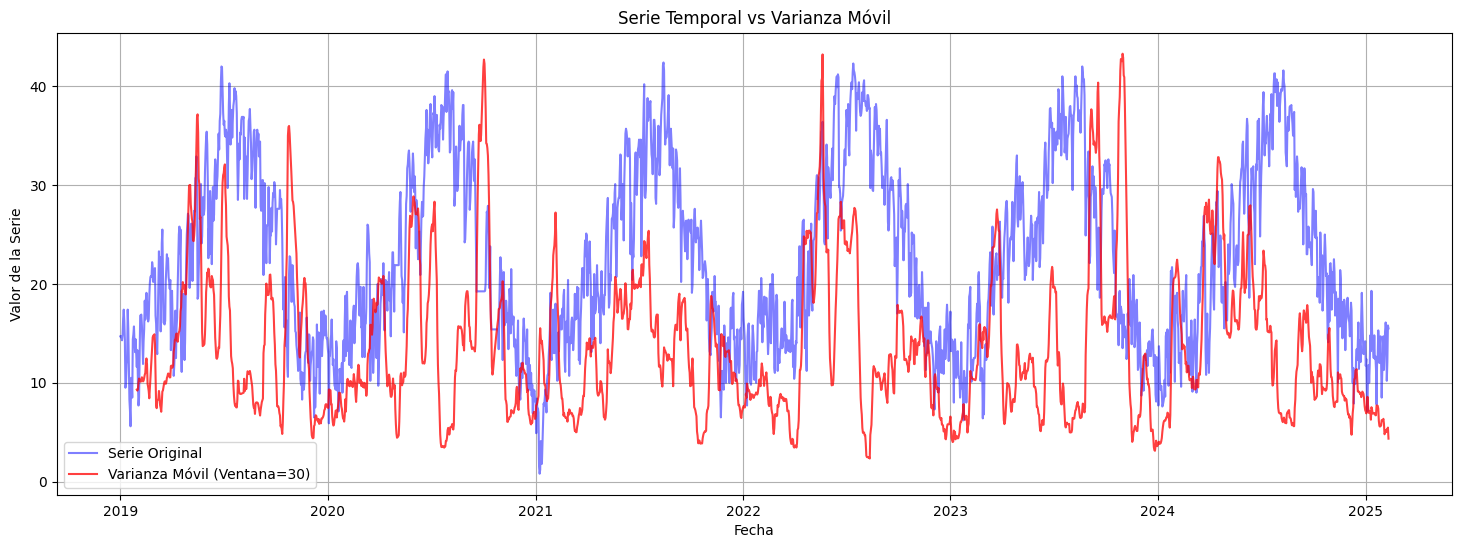

In [27]:
# Se puede ver que la varianza varia mas que la media y hay un pico en 2021 

# Tamaño de la ventana para la media móvil
window_size = 30  

# Calcula la media móvil
df['Rolling_var'] = df["tmax"].rolling(window=window_size).var()

# Graficar la serie original y la media móvil
plt.figure(figsize=(18, 6))
plt.plot(df["fecha"], df['tmax'], label='Serie Original', color='blue', alpha=0.5)
plt.plot(df["fecha"], df['Rolling_var'], label=f'Varianza Móvil (Ventana={window_size})', color='red', alpha=0.75)


plt.title('Serie Temporal vs Varianza Móvil')
plt.xlabel('Fecha')
plt.ylabel('Valor de la Serie')
plt.legend()
plt.grid(True)
plt.show()


df.drop(columns=["Rolling_var"], inplace=True)

### DETECCIÓN DE OUTLIERS MEDIANTE EL FILTRO HAMPEL

- Detecta los outliers dentro de una ventana utlizando la mediana ya que la mediana no suele ser muy afectada por outliers.

In [28]:
window_size=30
n_sigma=3

#Calculate the median in a rolling centered window
rolling_median = df["tmax"].rolling(window_size, center=True).median()

#Calculate the median of the absolute deviations from the data’s median in a rolling centered window
mad = df["tmax"].rolling(window_size, center=True).apply(median_abs_deviation)

#Treshold 
threshold_min = rolling_median - n_sigma*mad
threshold_max = rolling_median + n_sigma*mad

df["outlier_hm"] = (np.abs(df["tmax"] - rolling_median) > n_sigma*mad)

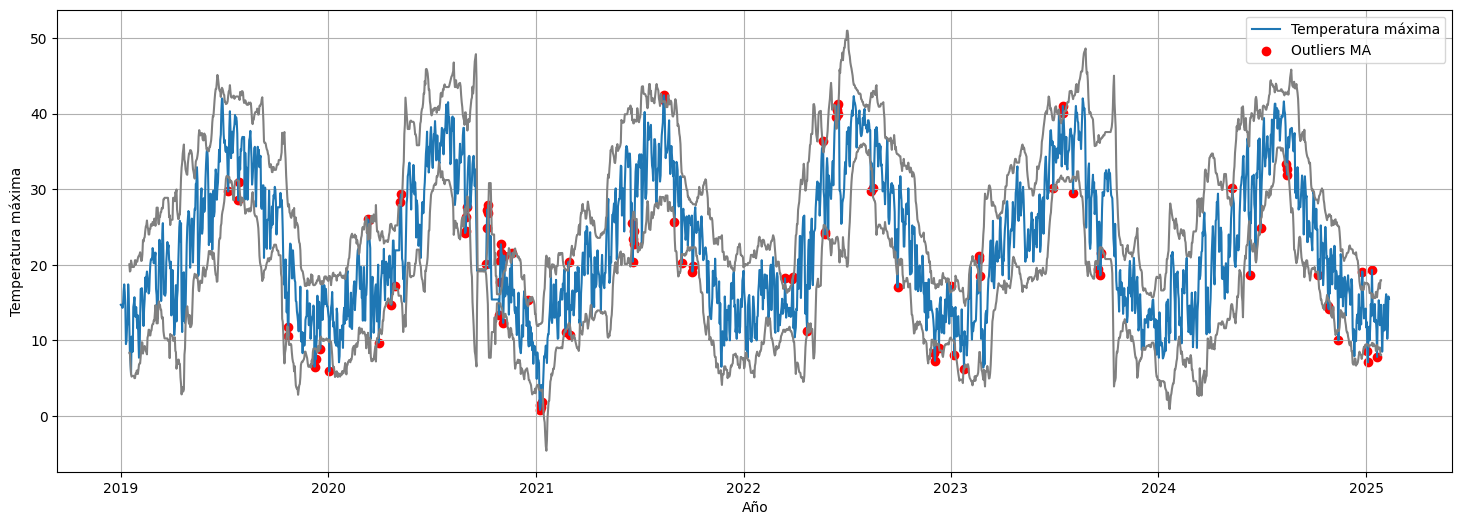

In [29]:
plt.figure(figsize=(18, 6))

plt.plot(df['fecha'], df['tmax'], label='Temperatura máxima')
plt.plot(df['fecha'], threshold_min, color='gray')
plt.plot(df['fecha'], threshold_max, color='gray')
plt.scatter(df["fecha"][df["outlier_hm"]], df["tmax"][df["outlier_hm"]], color='red', label="Outliers MA")
plt.xlabel('Año')
plt.ylabel('Temperatura máxima')
plt.legend()
plt.grid(True)
plt.show()


- Se detectan los outliers y se les imputa el valor calculado anteriormente, que esta representado como la linea gris.

In [30]:
# Imputar los outliers para que no superen el umbral
df["tmax_imputed"] = df["tmax"].copy()  # Copiar la columna original

# Reemplazar valores por debajo del umbral mínimo con el umbral mínimo
df.loc[df["tmax"] < threshold_min, "tmax_imputed"] = threshold_min

# Reemplazar valores por encima del umbral máximo con el umbral máximo
df.loc[df["tmax"] > threshold_max, "tmax_imputed"] = threshold_max

- Gráfica de los outliers y los valores actuales después de la imputación.

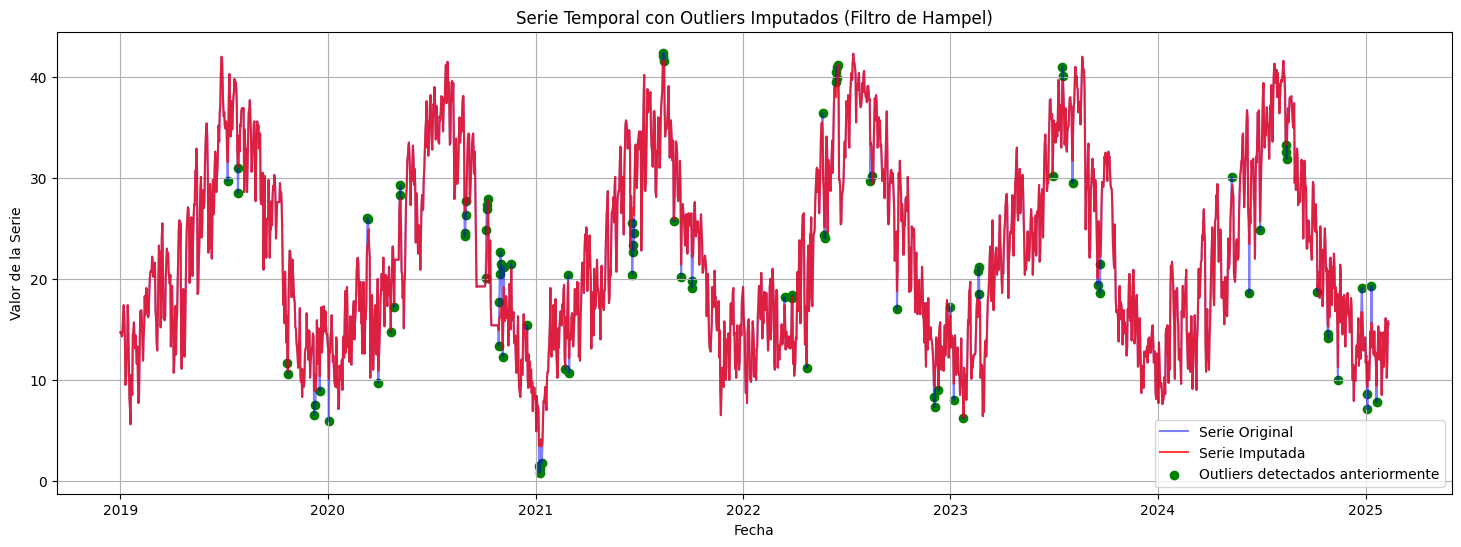

In [31]:
plt.figure(figsize=(18, 6))

# Serie temporal original
plt.plot(df["fecha"], df["tmax"], label="Serie Original", color="blue", alpha=0.5)

# Serie temporal con outliers imputados
plt.plot(df["fecha"], df["tmax_imputed"], label="Serie Imputada", color="red", alpha=0.75)

# Valores atípicos
outliers = df[df["outlier_hm"]]
plt.scatter(outliers["fecha"], outliers["tmax"], color="green", label="Outliers detectados anteriormente")


plt.title("Serie Temporal con Outliers Imputados (Filtro de Hampel)")
plt.xlabel("Fecha")
plt.ylabel("Valor de la Serie")
plt.legend()
plt.grid(True)
plt.show()

In [32]:
df.columns

Index(['fecha', 'tmed', 'tmin', 'tmax', 'velmedia', 'hrMedia', 'outlier_hm',
       'tmax_imputed'],
      dtype='object')

In [33]:
df["tmax"] = df["tmax_imputed"]
df.drop(columns=["outlier_hm","tmax_imputed"], inplace = True)

### COMPROBAR SI LA SERIE ES ESTACIONARIA

- El test de dickey duller detecta si existe una raíz unitaria en la serie temporal. Si la hay significa que no es estacionaria

In [34]:
# Realizar el Test ADF (Dickey-Fuller Aumentado)
adf_result = adfuller(df["tmax"])

# Imprimir los resultados del test ADF
print("Estadística de prueba ADF:", adf_result[0])
print("Valor p:", adf_result[1])
print("Valores críticos:", adf_result[4])

# Interpretación del resultado
if adf_result[1] < 0.05:
    print("Rechazamos la hipótesis nula: La serie es estacionaria")
else:
    print("No podemos rechazar la hipótesis nula: La serie tiene una raíz unitaria y no es estacionaria")

Estadística de prueba ADF: -2.868197709829208
Valor p: 0.049173126568436525
Valores críticos: {'1%': -3.4333057085868255, '5%': -2.8628457425162424, '10%': -2.567465109783999}
Rechazamos la hipótesis nula: La serie es estacionaria


### HUMEDAD MEDIA RELATIVA

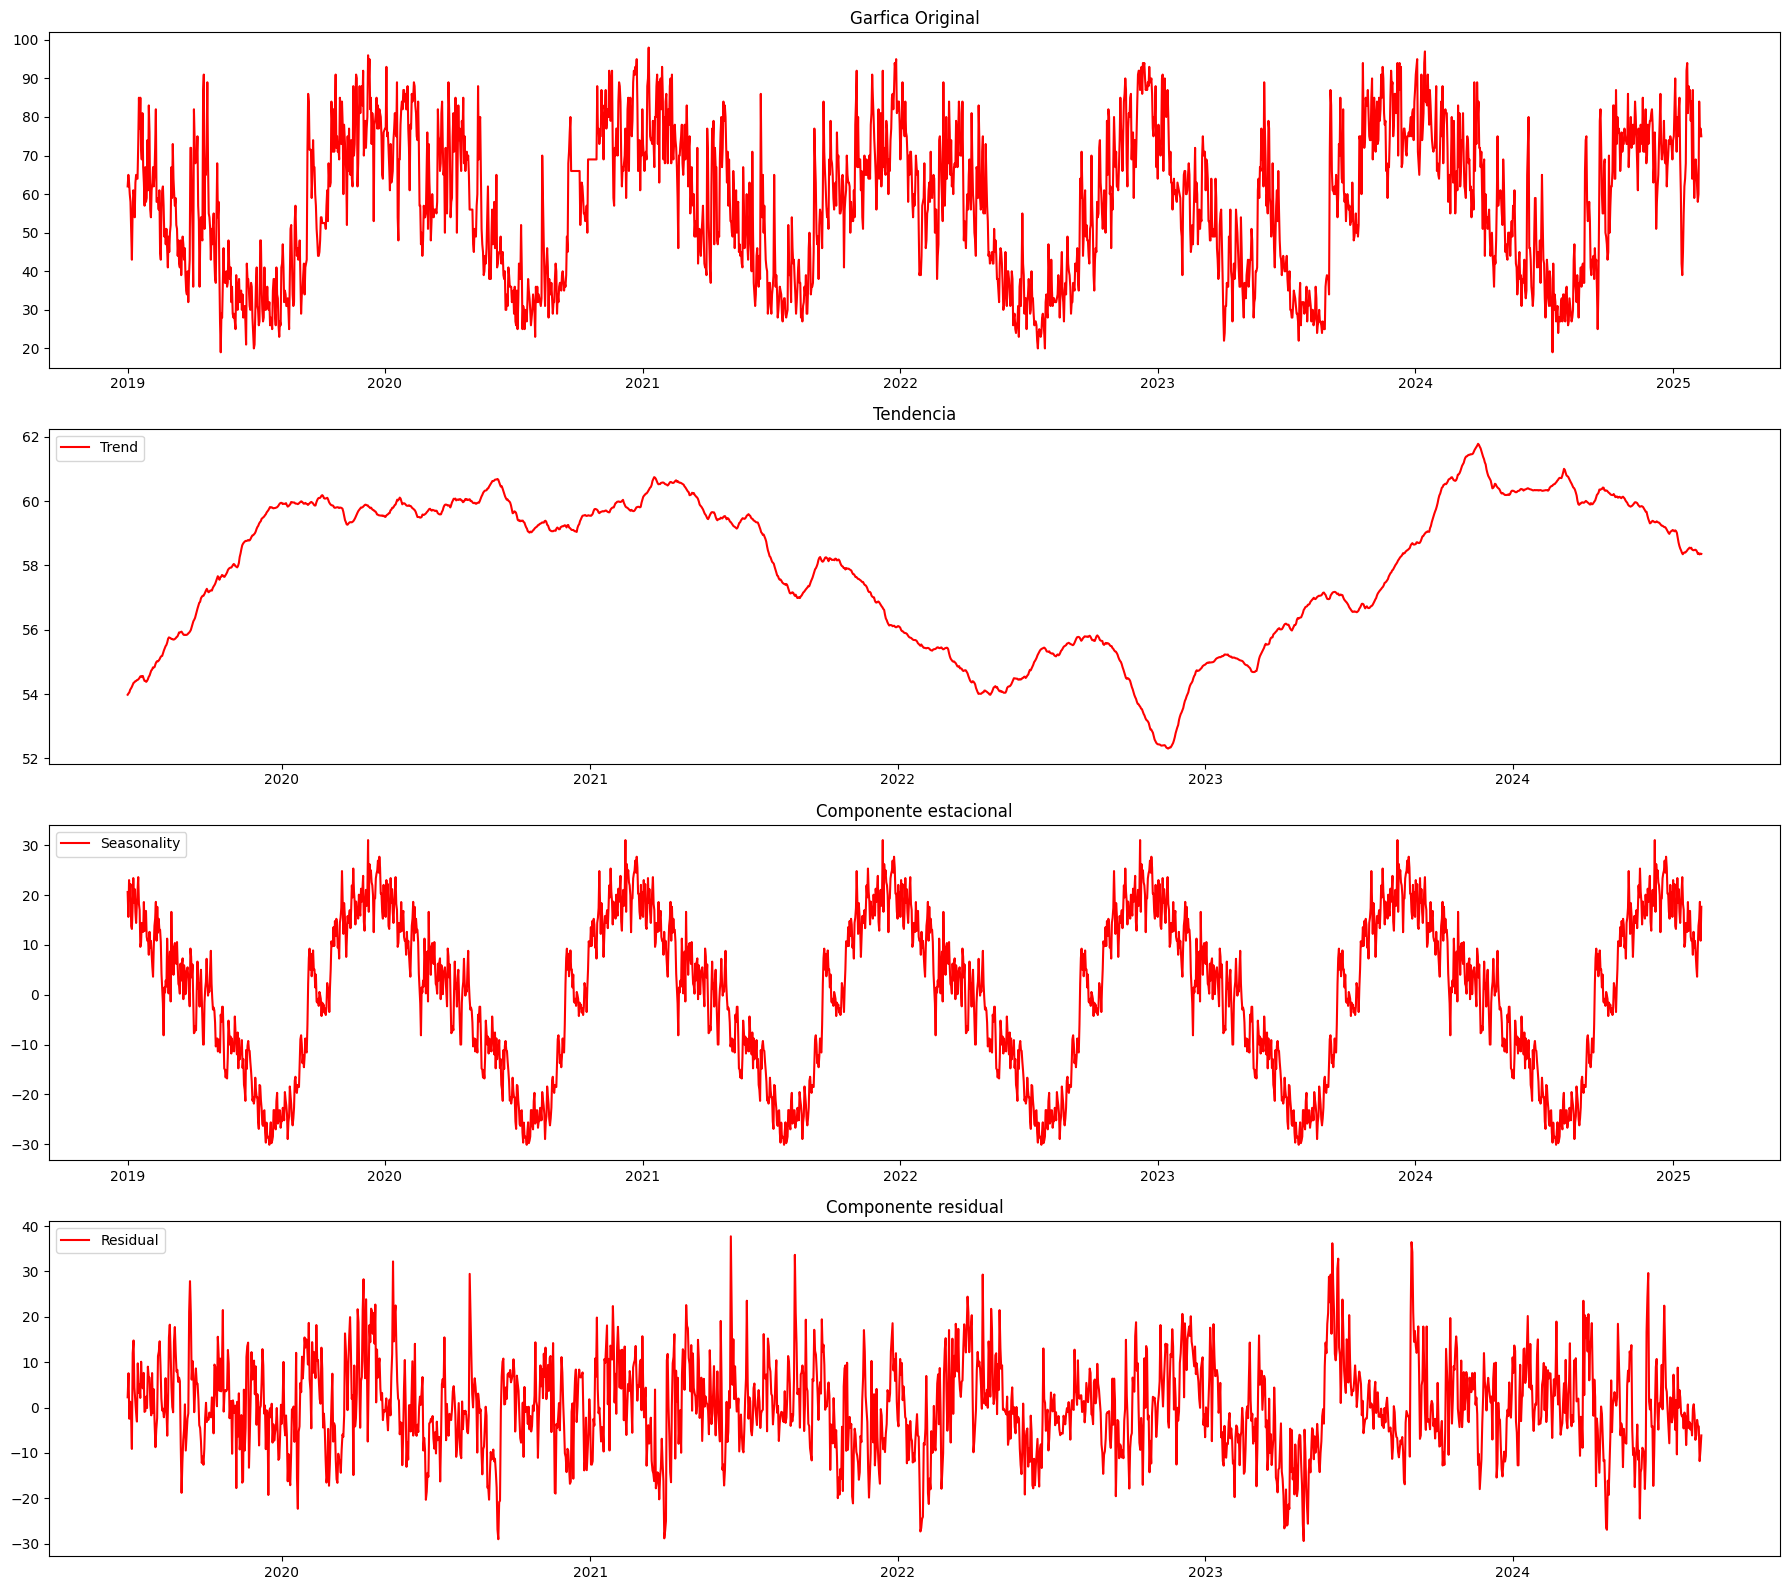

In [35]:
# Descomponer la serie temporal de la humedad relativa para mostrar la tendencia, estacionalidad y residuos
decomposition_hrMed = seasonal_decompose(df["hrMedia"], model='adittive', period=365)


plt.figure(figsize=(18, 16))

plt.subplot(4, 1, 1)
plt.plot(df["fecha"], df["hrMedia"], color="red")
plt.title('Garfica Original')

plt.subplot(4, 1, 2)
plt.plot(df["fecha"], decomposition_hrMed.trend, label='Trend', color="red")
plt.legend(loc='upper left')
plt.title('Tendencia')

plt.subplot(4, 1, 3)
plt.plot(df["fecha"], decomposition_hrMed.seasonal, label='Seasonality', color="red")
plt.legend(loc='upper left')
plt.title('Componente estacional')

plt.subplot(4, 1, 4)
plt.plot(df["fecha"], decomposition_hrMed.resid, label='Residual', color="red")
plt.legend(loc='upper left')
plt.title('Componente residual')

plt.tight_layout()
plt.show()

- Media móvil de la humedad relativa dentro de una ventana de 90 días.

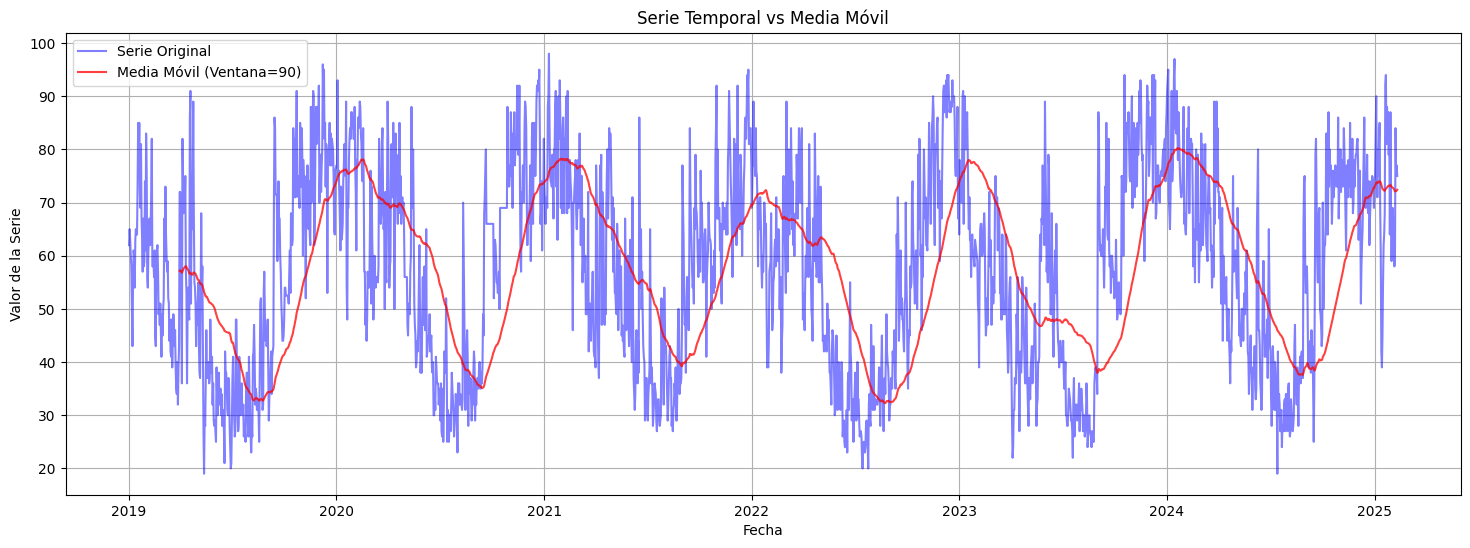

In [36]:
# Se puede ver que la media varía en ciertos momentos como a finales de 2023

# Tamaño de la ventana para la media móvil
window_size = 90  

# Calcula la media móvil
df['Rolling_Avg'] = df["hrMedia"].rolling(window=window_size).mean()

# Graficar la serie original y la media móvil
plt.figure(figsize=(18, 6))
plt.plot(df["fecha"], df['hrMedia'], label='Serie Original', color='blue', alpha=0.5)
plt.plot(df["fecha"], df['Rolling_Avg'], label=f'Media Móvil (Ventana={window_size})', color='red', alpha=0.75)


plt.title('Serie Temporal vs Media Móvil')
plt.xlabel('Fecha')
plt.ylabel('Valor de la Serie')
plt.legend()
plt.grid(True)
plt.show()


df.drop(columns=["Rolling_Avg"], inplace=True)

- Varianza de la humedad relativa dentro de una ventana de 30 días.

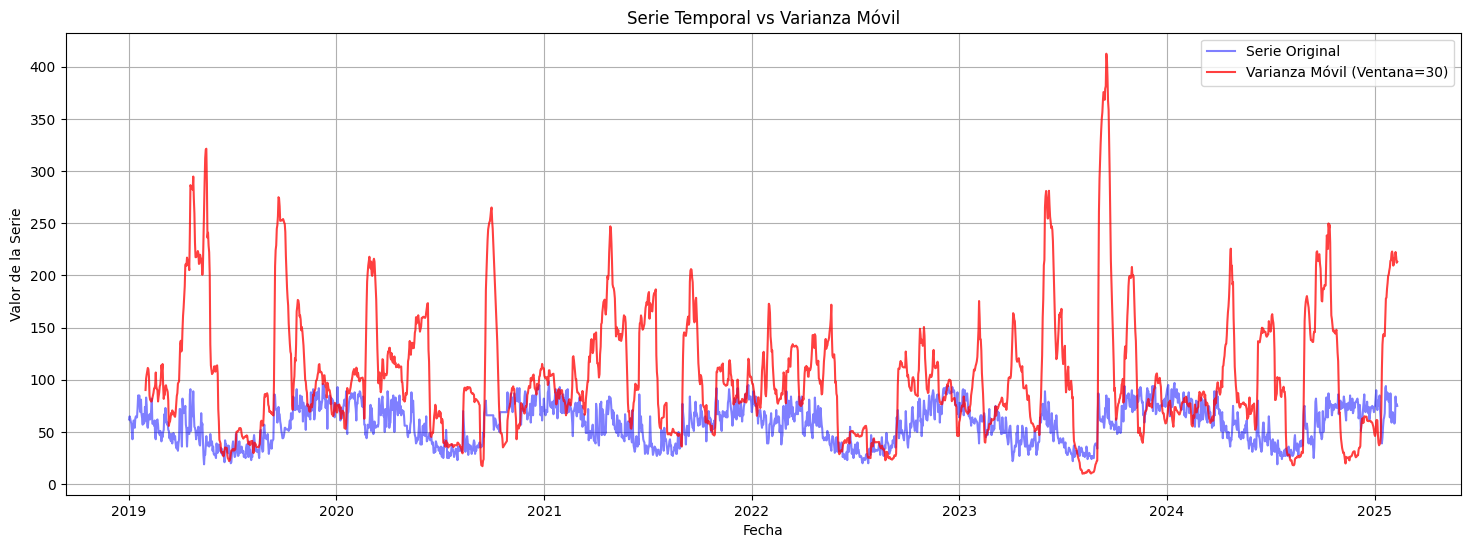

In [37]:
# Se puede ver que la varianza varia mas que la media y hay un pico a finales de 2023

# Tamaño de la ventana para la media móvil
window_size = 30  

# Calcula la media móvil
df['Rolling_var'] = df["hrMedia"].rolling(window=window_size).var()

# Graficar la serie original y la media móvil
plt.figure(figsize=(18, 6))
plt.plot(df["fecha"], df['hrMedia'], label='Serie Original', color='blue', alpha=0.5)
plt.plot(df["fecha"], df['Rolling_var'], label=f'Varianza Móvil (Ventana={window_size})', color='red', alpha=0.75)


plt.title('Serie Temporal vs Varianza Móvil')
plt.xlabel('Fecha')
plt.ylabel('Valor de la Serie')
plt.legend()
plt.grid(True)
plt.show()


df.drop(columns=["Rolling_var"], inplace=True)

### DETECCIÓN DE OUTLIERS MEDIANTE EL FILTRO DE HAMPEL

- Detecta los outliers dentro de una ventana utlizando la mediana ya que la mediana no suele ser muy afectada por outliers.

In [38]:
window_size=30
n_sigma=3

#Calculate the median in a rolling centered window
rolling_median = df["hrMedia"].rolling(window_size, center=True).median()

#Calculate the median of the absolute deviations from the data’s median in a rolling centered window
mad = df["hrMedia"].rolling(window_size, center=True).apply(median_abs_deviation)

#Treshold 
threshold_min = rolling_median - n_sigma*mad
threshold_max = rolling_median + n_sigma*mad

df["outlier_hm"] = (np.abs(df["hrMedia"] - rolling_median) > n_sigma*mad)

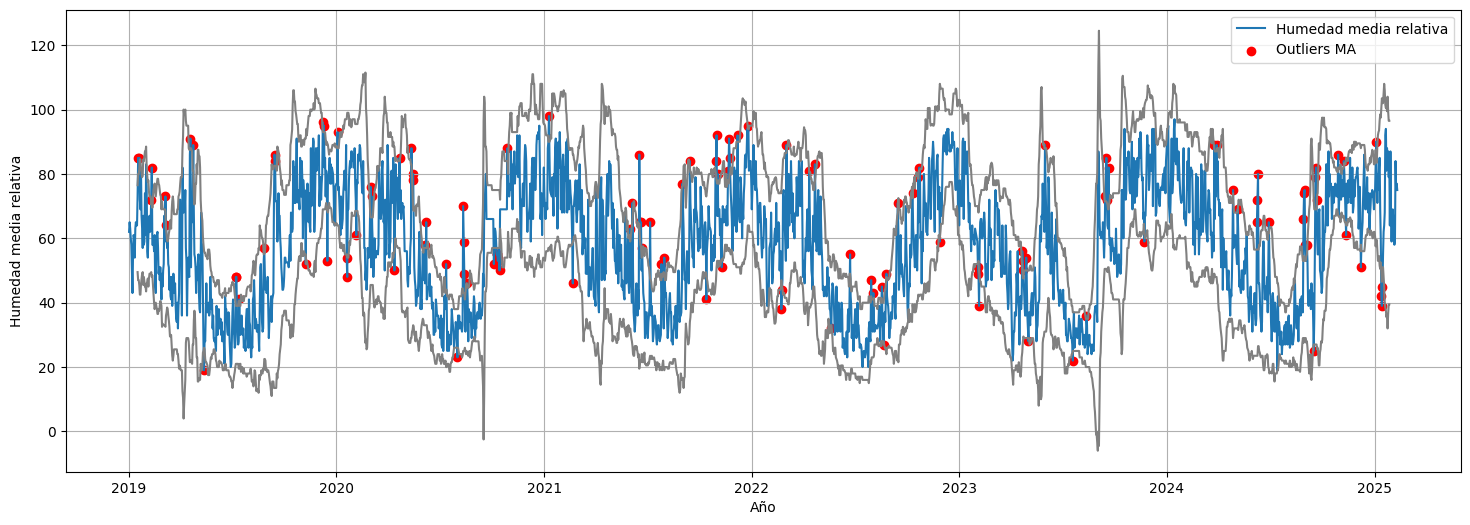

In [39]:
plt.figure(figsize=(18, 6))

plt.plot(df['fecha'], df['hrMedia'], label='Humedad media relativa')
plt.plot(df['fecha'], threshold_min, color='gray')
plt.plot(df['fecha'], threshold_max, color='gray')
plt.scatter(df["fecha"][df["outlier_hm"]], df["hrMedia"][df["outlier_hm"]], color='red', label="Outliers MA")
plt.xlabel('Año')
plt.ylabel('Humedad media relativa')
plt.legend()
plt.grid(True)
plt.show()


- Se detectan los outliers y se les imputa el valor calculado anteriormente, que esta representado como la linea gris.

In [40]:
# Imputar los outliers para que no superen el umbral
df["hrMedia_imputed"] = df["hrMedia"].copy()  # Copiar la columna original

# Reemplazar valores por debajo del umbral mínimo con el umbral mínimo
df.loc[df["hrMedia"] < threshold_min, "hrMedia_imputed"] = threshold_min

# Reemplazar valores por encima del umbral máximo con el umbral máximo
df.loc[df["hrMedia"] > threshold_max, "hrMedia_imputed"] = threshold_max

- Gráfica de los outliers y los valores actuales después de la imputación

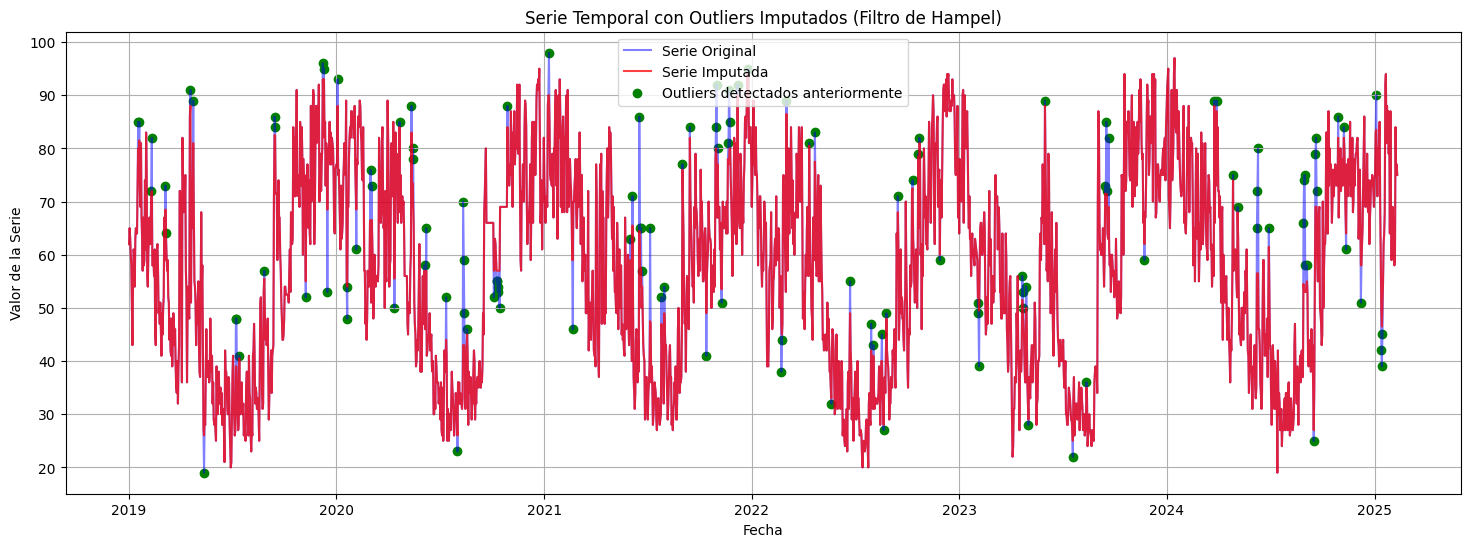

In [41]:
plt.figure(figsize=(18, 6))

# Serie temporal original
plt.plot(df["fecha"], df["hrMedia"], label="Serie Original", color="blue", alpha=0.5)

# Serie temporal con outliers imputados
plt.plot(df["fecha"], df["hrMedia_imputed"], label="Serie Imputada", color="red", alpha=0.75)

# Valores atípicos
outliers = df[df["outlier_hm"]]
plt.scatter(outliers["fecha"], outliers["hrMedia"], color="green", label="Outliers detectados anteriormente")


plt.title("Serie Temporal con Outliers Imputados (Filtro de Hampel)")
plt.xlabel("Fecha")
plt.ylabel("Valor de la Serie")
plt.legend()
plt.grid(True)
plt.show()

In [42]:
df.columns

Index(['fecha', 'tmed', 'tmin', 'tmax', 'velmedia', 'hrMedia', 'outlier_hm',
       'hrMedia_imputed'],
      dtype='object')

In [43]:
df["hrMedia"] = df["hrMedia_imputed"]
df.drop(columns=["outlier_hm","hrMedia_imputed"], inplace =True)

### COMPROBAR SI LA SERIE ES ESTACIONARIA

- El test de dickey duller detecta si existe una raíz unitaria en la serie temporal. Si la hay significa que no es estacionaria.

In [44]:
# Realizar el Test ADF (Dickey-Fuller Aumentado)
adf_result = adfuller(df["hrMedia"])

# Imprimir los resultados del test ADF
print("Estadística de prueba ADF:", adf_result[0])
print("Valor p:", adf_result[1])
print("Valores críticos:", adf_result[4])

# Interpretación del resultado
if adf_result[1] < 0.05:
    print("Rechazamos la hipótesis nula: La serie es estacionaria")
else:
    print("No podemos rechazar la hipótesis nula: La serie tiene una raíz unitaria y no es estacionaria")

Estadística de prueba ADF: -3.749491449547142
Valor p: 0.0034684828662407126
Valores críticos: {'1%': -3.4332990438642623, '5%': -2.8628427996988957, '10%': -2.567463542934827}
Rechazamos la hipótesis nula: La serie es estacionaria


In [ ]:
base_dir = os.getcwd()
demandas_path = os.path.join(
    base_dir, "..","..", "data", "homogeneized","Alcala_Henares", "datos_Alcala_Henares_homogenizados.csv"
)
df.to_csv(demandas_path, index=False)